<div align="center">
  <h1>Analyzing Global Atmospheric Temperature Trends Using MATLAB/Octave</h1>
</div>

## Introduction

This report aims to conduct an in-depth examination of global atmospheric temperature patterns utilizing MATLAB/Octave software. The data under scrutiny originates from the University of Alabama, Huntsville (UAH), specifically curated by John Christy's research group. This dataset encompasses unprocessed satellite data from the National Space Science and Technology Centre, predominantly derived from the NOAA series of satellites, with the AQUA satellite entering operational status from the middle of 2002 onward [4].

The report commences by delving into data processing, visualization, and identifying correlations among temperature, sunspot activity, and atmospheric transparency. Subsequently, we employ these correlations and conduct regression analysis to mitigate the statistical impact of these two pivotal factors. The ensuing outcomes will be leveraged to assess prolonged trends and engage in a thorough exploration of significant trends and associated questions.

## Data and Preprocessing

This simple demo of octave-based data plotting is based on the publicly-available data from UAH (University of Alabama, Huntsville), as reported by the group of John Christy <christy@atmos.uah.edu>. The raw satellite data (NOAA series of satellites; AQUA, starting in mid-2002) from the National Space Science and Technology Centre (http://vortex.nsstc.uah.edu/) is extensively verified and corrected for calibration errors, as those are detected. For example, camera drift as NOAA-18 and NOAA-19 satellites aged was discovered and corrected in 2017, as described <a href="https://www.nsstc.uah.edu/climate/2019/march2019/GTR_201903Mar_1.pdf" target="_blank">here</a>. This is the best large-scale atmospheric temperature data that we (the humans) have, free of any bias that may (or may not) exist in the surface-measured temperatures. [4]

 We will first download the data to start the data processing.

In [1]:
### This sets the Jupyter working directory
%cd ~/5P10

In [2]:
### this sets the Octave working directory and search path
cd ~/5P10
addpath("~/5P10")

error: ~/5P10: No such file or directory


The following only needs to be done once, using either method below. Rather than read the external data files directly, we first make local copies using the operating system command <code>wget</code> or <code>urlwrite(external_URL,local_file_name)</code>:

In [3]:
### retrieval of files across the network could be deferred to the operating system
### the advantage is that the files will only be downloaded if they changed at the source
system('wget -Nq https://www.nsstc.uah.edu/data/msu/v6.0/tls/uahncdc_ls_6.0.txt');
system('wget -Nq https://www.nsstc.uah.edu/data/msu/v6.0/tmt/uahncdc_mt_6.0.txt');
system('wget -Nq https://www.nsstc.uah.edu/data/msu/v6.0/tlt/uahncdc_lt_6.0.txt');
system('wget -Nq http://www.sidc.be/silso/DATA/SN_m_tot_V2.0.txt');
system('wget -Nq https://solarscience.msfc.nasa.gov/greenwch/sunspot_area.txt');

In [4]:
### this is a pure octave call, and will download every time, even if there was no change
urlwrite('https://www.nsstc.uah.edu/data/msu/v6.0/tls/uahncdc_ls_6.0.txt','uahncdc_ls_6.0.txt');
urlwrite('https://www.nsstc.uah.edu/data/msu/v6.0/tmt/uahncdc_mt_6.0.txt','uahncdc_mt_6.0.txt');
urlwrite('https://www.nsstc.uah.edu/data/msu/v6.0/tlt/uahncdc_lt_6.0.txt','uahncdc_lt_6.0.txt');

# Sunspot count data from WDC-SILSO, Royal Observatory of Belgium, Brussels
# column format: year, month, decimal year, SNvalue , SNerror, Nb observations
# monthly averages. The file has no header.
urlwrite('http://www.sidc.be/silso/DATA/SN_m_tot_V2.0.txt','SN_m_tot_V2.0.txt');

# Monthly averages of the daily sunspot areas, x1e-6 of hemisphere. From dave.hathaway@comcast.net
# - first line is the header with column titles 
# - whitespace as separators (default is comma ',') 
urlwrite('https://solarscience.msfc.nasa.gov/greenwch/sunspot_area.txt','sunspot_area.txt');

Loading important packages required for preprocessing

In [ ]:
### only need to do this once
### this signal-processing package contains Savitsky-Golay filter implementation
pkg load signal;
### this is a useful way of keeping all data in one place
pkg load dataframe;
### needed for regression analysis
pkg load statistics;


This code reads data from various files, processes it, and extracts specific columns. It also converts year and month information into decimal dates. Additionally, it applies a smoothing filter to sunspot count and sunspot area data.

In [ ]:
### read in the local file, skipping the first line as a header, to the end, only the first three columns
d = dlmread('uahncdc_ls_6.0.txt','',[1 0 inf 2]);
### make a decimal date out of year + (month-0.5)/12, i.e. place time at mid-month
### v 6.0 data has a nine-line footer in the file, skip that
year = d(1:end-9,1)+(d(1:end-9,2)-0.5)/12;
t_ls = d(1:end-9,3);
### only need the third columns from the other two data files, year and month are the same
d = dlmread('uahncdc_mt_6.0.txt','',[1 0 inf 2]);
t_mt = d(1:end-9,3);
d = dlmread('uahncdc_lt_6.0.txt','',[1 0 inf 2]);
t_lt = d(1:end-9,3);

### sunspot count data goes back many more years, no header, no footer
# column format: year, month, decimal year, SNvalue , SNerror, Nb observations
d = dlmread('SN_m_tot_V2.0.txt','',[0 0 inf 4]);
sc_year = d(:,1)+(d(:,2)-0.5)/12;
sc = sgolayfilt(d(:,4),2,13);

### sunspot area data goes back many more years, one-line header, no footer
d = dlmread('sunspot_area.txt','',[1 0 inf 2]);
sa_year = d(:,1)+(d(:,2)-0.5)/12;
sa = sgolayfilt(d(:,3),2,13);  



Notes:
<ul>
    <li>temperature data: read in the first three columns only, skipping the first (header) line, then convert the first two columns (year,month) into a single decimal year value. Also, truncate the tail end of each dataset, to account for a trailing footer made up of nine text lines;</li>
    <li>sunspot count data: there is no header, but the decimal year value is already pre-calculated (in column 3), use it;</li>
    <li>sunspot area data: one-line header, make the decimal year out of year,month;</li>
    <li>sunspot area data is better than mere sunspot count, but it stops in 2016, as the funding ran out :-(</li>
    <li>all sunspot data is noisy, apply Savitsky-Golay second-order 13-point filter.[4] </li> 
</ul>

## Visualization and Correlations

The most obvious influencer is the solar input, and a visual inspection confirms that there is a likely correlation between the solar activity and the atmospheric temperatires. 
This macro below creates a figure with two subplots. The first subplot shows the changes in global average atmospheric temperatures for different layers of the atmosphere. The second subplot displays the average daily sunspot area and sunspot count over time.

In [7]:
%plot inline -w 900 -h 600 

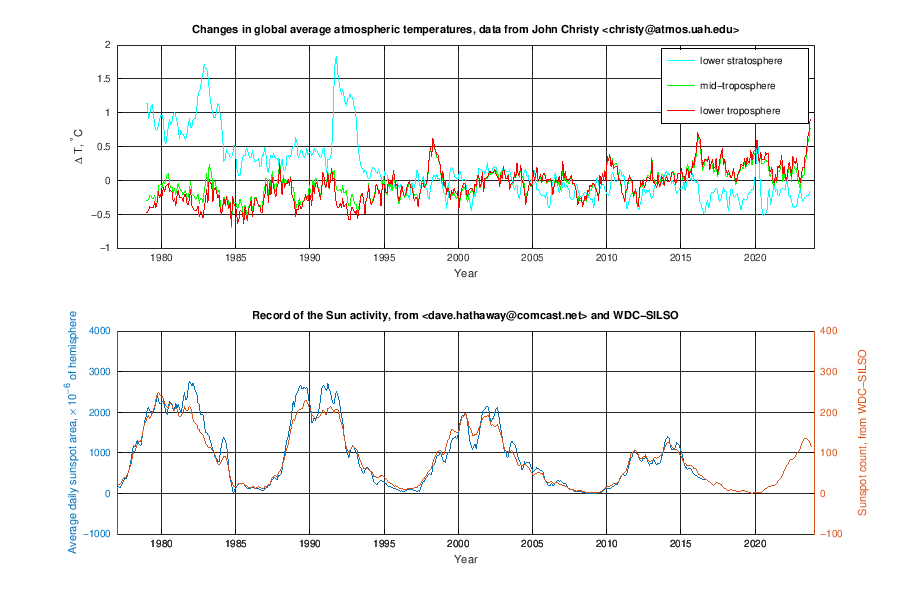

In [ ]:
subplot(2,1,1);
plot(year,t_ls,'c-;lower stratosphere;',    % Plot lower stratosphere temperature
     year,t_mt,'g-;mid-troposphere;',       % Plot mid-troposphere temperature
     year,t_lt,'r-;lower troposphere;');    % Plot lower troposphere temperature
xlim([1977,2024]);                          % Set x-axis limits
ylabel('\Delta T, ^{\circ}C');              % Label for y-axis
xlabel('Year');                             % Label for x-axis
box on;                                     % Display box around plot
grid on;                                    % Display grid lines
title('Changes in global average atmospheric temperatures, data from John Christy <christy@atmos.uah.edu>'); % Set plot title

subplot(2,1,2);
[ax,h1,h2] = plotyy(sa_year,sa,sc_year,sc); % Plot sunspot area and sunspot count on dual y-axes
xlim(ax(1),[1977,2024]);                    % Set x-axis limits for first y-axis
xlim(ax(2),[1977,2024]);                    % Set x-axis limits for second y-axis
ylabel (ax(1), 'Average daily sunspot area, \times 10^{-6} of hemisphere'); % Label for first y-axis
ylabel (ax(2), 'Sunspot count, from WDC-SILSO');                            % Label for second y-axis
xlabel('Year');                             % Label for x-axis
%legend([h1 h2],'sunspot area','sunspot count');
box on;                                     % Display box around plot
grid on;                                    % Display grid lines
title('Record of the Sun activity, from <dave.hathaway@comcast.net> and WDC-SILSO'); % Set plot title




Clearly, some of the oscillations observed in the temperature data have the same periodicity and are similar in phase to the Sun activity as reported by either of the sun spots data. The next step is to perform some form of regression analysis, to try to remove the effects of this strong influencer.[4]
<p>
However, it is also obvious, especially from the lower stratospheric data, that something else has a dramatic short-term effect on temperature. The two peaks at 1982-93 and 1992-93 stand out. These seem to correspond to the time of two major recent volcaninc eruptions, El Chichon (Mexico, 1982) and Mt. Pinatubo (Phillipines, June 1991). Therefore, full analysis will have to include multiple regressions against both the solar activity and the atmospheric transmission rate which was greatly affected by the volcanic ash emissions.[4]
<p>
Unfortunately, the data for atmospheric transparency is not as extensive, and some missing dates may need to be excluded from consideration. The atmospheric transmission data is derived from the measurements of direct solar radiation at Mauna Loa, Hawaii. The reason why the data measured at a location in Hawaii are very valuable for the global records is because of its remote location from any anthropogenic activities and pollution sources, other land-related events, cross-Atlantic dust storm signatures or continent weather conditions. It is not a perfect global marker; for example, the April 2010 volcanic eruption in Iceland (Eyjafjallajökull) does not seem to affect the Mauna Loa data very strongly, with only a small feature around 2010. Still, it is a good starting point.[4]
<p>
First we download the transparency data and add another graph to the previous plot(s). The transparency decreases due to volcanic eruptions appear to be highly correlated with prominent temperature peaks in the lower statosphere.[4]

In [9]:
system('wget -Nq https://www.esrl.noaa.gov/gmd/webdata/grad/mloapt/mlo_transmission.dat');
### or this:
#urlwrite('https://www.esrl.noaa.gov/gmd/webdata/grad/mloapt/mlo_transmission.dat','mlo_transmission.dat');

In [10]:
### transparency data has a two-line header, no footer
### columns are MMM-YYYY, decimal_year, transparency
# MLO Apparent Transmission Values
# (Morning, monthly means)
# JAN-1958   1958.0416      0.9364
# ...
d = dlmread('mlo_transmission.dat','',[2 0 inf 3]);  % Read data from file 'mlo_transmission.dat', skipping the first 2 rows, and taking columns 2 and 3
tr_year = d(:,2);                                    % Assign the second column to 'tr_year'
tr = d(:,3);                                         % Assign the third column to 'tr'


This code below generates a figure with three subplots. The first subplot displays changes in global average atmospheric temperatures for different layers of the atmosphere. The second subplot shows the average daily sunspot area and sunspot count over time. The third subplot represents Mauna Loa (Hawaii) atmospheric transparency in terms of apparent transmission.

In [ ]:
%plot inline -w 900 -h 900


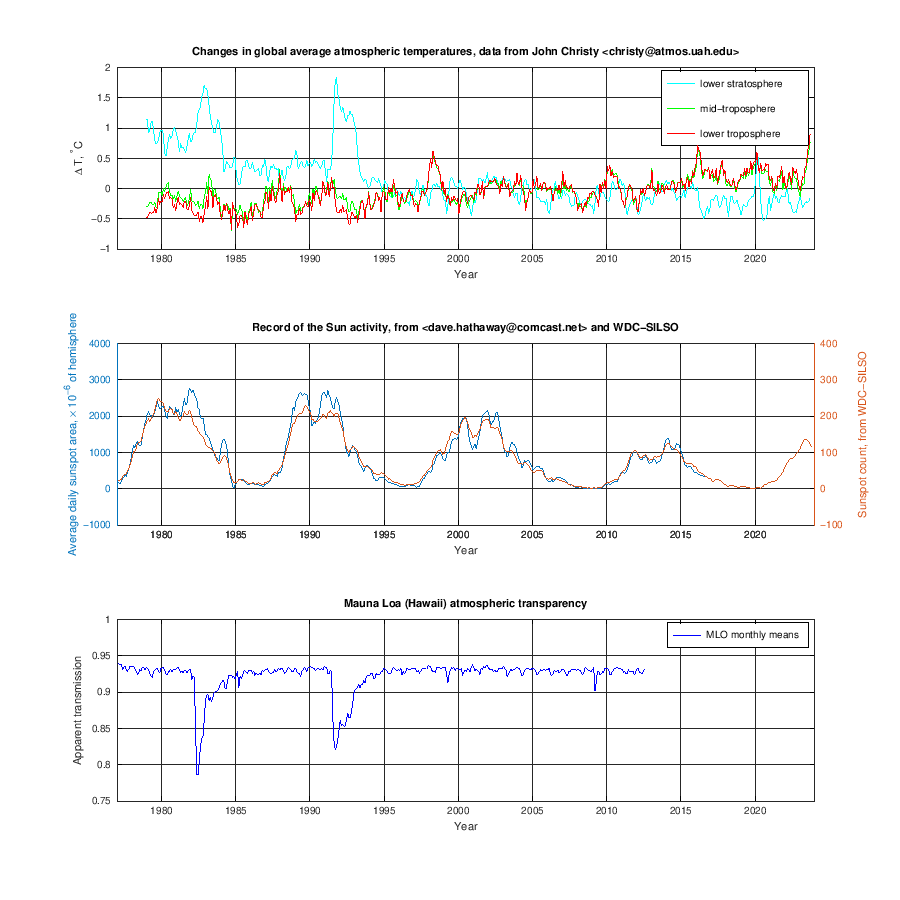

In [12]:
subplot(3,1,1);
plot(year,t_ls,'c-;lower stratosphere;',              % Plot lower stratosphere temperature
     year,t_mt,'g-;mid-troposphere;',                 % Plot mid-troposphere temperature
     year,t_lt,'r-;lower troposphere;');              % Plot lower troposphere temperature
xlim([1977,2024]);                                    % Set x-axis limits
ylabel('\Delta T, ^{\circ}C');                        % Label for y-axis
xlabel('Year');                                       % Label for x-axis
box on;                                               % Display box around plot
grid on;                                              % Display grid lines
title('Changes in global average atmospheric temperatures, data from John Christy <christy@atmos.uah.edu>'); % Set plot title

subplot(3,1,2);
[ax,h1,h2] = plotyy(sa_year,sa,sc_year,sc);           % Plot sunspot area and sunspot count on dual y-axes
xlim(ax(1),[1977,2024]);                              % Set x-axis limits for first y-axis
xlim(ax(2),[1977,2024]);                              % Set x-axis limits for second y-axis
ylabel (ax(1), 'Average daily sunspot area, \times 10^{-6} of hemisphere'); % Label for first y-axis
ylabel (ax(2), 'Sunspot count, from WDC-SILSO');                            % Label for second y-axis
xlabel('Year');                                       % Label for x-axis
box on;                                               % Display box around plot
grid on;                                              % Display grid lines
title('Record of the Sun activity, from <dave.hathaway@comcast.net> and WDC-SILSO'); % Set plot title

subplot(3,1,3);
plot(tr_year,tr,'b-;MLO monthly means;');              % Plot MLO monthly means
xlim([1977,2024]);                                    % Set x-axis limits
ylabel('Apparent transmission');                      % Label for y-axis
xlabel('Year');                                       % Label for x-axis
box on;                                               % Display box around plot
grid on;                                              % Display grid lines
title('Mauna Loa (Hawaii) atmospheric transparency'); % Set plot title



Dataframes are objects that offer database or spreadsheet-like properties. After you have all your data gathered into a single dataframe, with descriptive headers, column types (strings, numerical values, etc.) established, and erratic or missing values identified, certain global operations become particularly simple. [4]
<p>
In order to analyze the atmospheric temperature data further and to perform some statistical or other forms of analysis, we blend into a dataframe the data on solar activity from two different sources. Since the data in this case is a time series of measurements we establish a common timebase index for all data.[4]

In [13]:
### give columns meaningfuls names
Columns = ["Year";"T_lowstrato";"T_midtropo";"T_lowtropo";"SunSpotArea";"SunSpotCount";"MLOtransparency"];

### create a dataframe, and append two NaN-filled columns for sunspot data 
zc = NaN(length(year),1);
df = dataframe([year,t_ls,t_mt,t_lt,zc,zc,zc]);
df.colnames = Columns;

### for each temperature data point, find and fill the sunspot values 
for i = 1:length(year)
  df.SunSpotArea(i)=sa( abs(sa_year - year(i)) < 0.01 );
  df.SunSpotCount(i)=sc( abs(sc_year - year(i)) < 0.01 );
  df.MLOtransparency(i)=tr(  abs(tr_year - year(i)) < 0.01 );
endfor

### print out a few lines at the top and bottom of the dataframe
df([1:5,end-5:end],Columns)

ans = dataframe with 11 rows and 7 columns                                           
 _1   Year T_lowstrato T_midtropo T_lowtropo SunSpotArea SunSpotCount MLOtransparency
 Nr double      double     double     double      double       double          double
  1 1979.0     1.14000  -0.300000   -0.48000      1895.3       179.18         0.93380
  2 1979.0     1.14000  -0.300000   -0.48000      2068.2       187.28         0.93270
  3 1979.1     0.92000  -0.280000   -0.44000      2123.4       192.48         0.93150
  4 1979.2     0.98000  -0.220000   -0.39000      2024.8       184.01         0.92580
  5 1979.3     1.09000  -0.230000   -0.41000      2029.6       190.89         0.92200
533 2023.3    -0.28000   0.070000    0.18000         NaN       134.02             NaN
534 2023.4    -0.24000   0.300000    0.37000         NaN       135.57             NaN
535 2023.5    -0.22000   0.320000    0.38000         NaN       135.22             NaN
536 2023.5    -0.24000   0.540000    0.64000         N

## Multi-factor Regression Analysis

A full regression analysis can calculate the statistical influence of the two major factors, and remove them from the data. Other effects and long-term trends in the data that may be obscured by these major influencers, may then become apparent.  However, it is clear that there could be a time lag between a rise in ash emissions and the associated reduction in the amount of radiation reaching the surface, and any temperature changes in the various layers of the atmosphere. In fact, each of the identified layers may well have its own time delay, different from the others. [4]

The macro below performs correlation and cross-covariance analyses on temperature data and sunspot count, as well as temperature data and atmospheric transparency. It then generates two sets of subplots to visualize the results. The first set examines the correlation between temperature and sunspot count, while the second set focuses on the correlation between temperature and atmospheric transparency. [4]

In [14]:
%plot inline -w 900 -h 600

ans =

   0.55323
  -0.17420
  -0.27080

ans =

  -0.65813
   0.15691
   0.35029



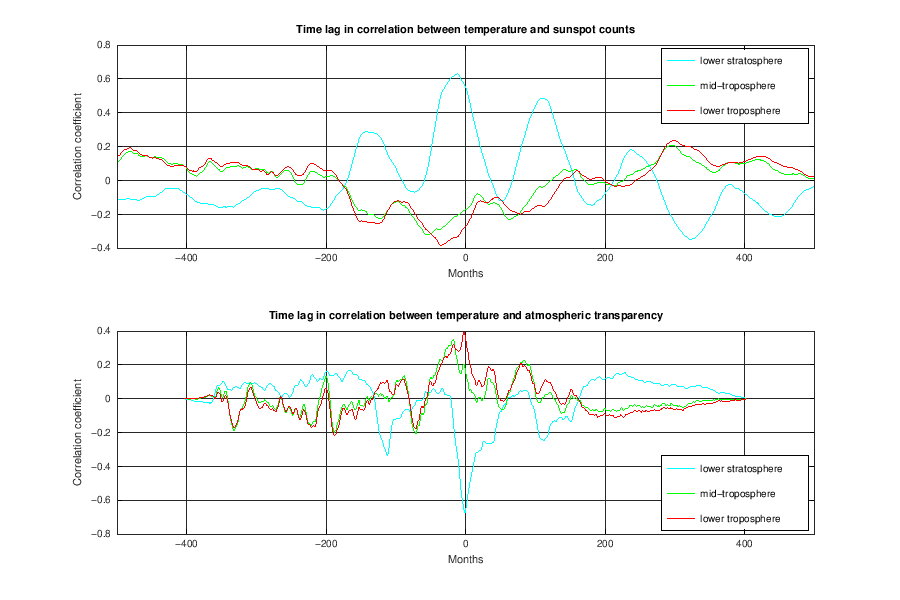

In [15]:
### SunSpot count data is available for all dates
corr([df.T_lowstrato, df.T_midtropo, df.T_lowtropo], df.SunSpotCount)               % Calculate correlation between temperature and sunspot count
[R_ls,lag_ls] = xcov(df.SunSpotCount,df.T_lowstrato,'coeff');                       % Cross-covariance between sunspot count and lower stratosphere temperature
[R_mt,lag_mt] = xcov(df.SunSpotCount,df.T_midtropo,'coeff');                        % Cross-covariance between sunspot count and mid-troposphere temperature
[R_lt,lag_lt] = xcov(df.SunSpotCount,df.T_lowtropo,'coeff');                        % Cross-covariance between sunspot count and lower troposphere temperature

subplot(2,1,1);
plot(lag_ls,R_ls,'c-;lower stratosphere;',                                          % Plot lower stratosphere correlation
     lag_mt,R_mt,'g-;mid-troposphere;',                                             % Plot mid-troposphere correlation
     lag_lt,R_lt,'r-;lower troposphere;');                                          % Plot lower troposphere correlation
ylabel('Correlation coefficient');                                                  % Label for y-axis
xlabel('Months');                                                                   % Label for x-axis
xlim([-500,500]);                                                                   % Set x-axis limits
box on;                                                                             % Display box around plot
grid on;                                                                            % Display grid lines
title('Time lag in correlation between temperature and sunspot counts');            % Set plot title

### transparency is missing some dates, use only the ones that have all data
df1 = df([~isnan(df.MLOtransparency)],Columns);                                     % Remove rows with missing transparency data
corr ([df1.T_lowstrato, df1.T_midtropo, df1.T_lowtropo], df1.MLOtransparency)       % Calculate correlation between temperature and atmospheric transparency
[RR_ls,llag_ls] = xcov(df1.MLOtransparency,df1.T_lowstrato,'coeff');                % Cross-covariance between transparency and lower stratosphere temperature
[RR_mt,llag_mt] = xcov(df1.MLOtransparency,df1.T_midtropo,'coeff');                 % Cross-covariance between transparency and mid-troposphere temperature
[RR_lt,llag_lt] = xcov(df1.MLOtransparency,df1.T_lowtropo,'coeff');                 % Cross-covariance between transparency and lower troposphere temperature

subplot(2,1,2);
plot(llag_ls,RR_ls,'c-;lower stratosphere;',                                        % Plot lower stratosphere correlation
     llag_mt,RR_mt,'g-;mid-troposphere;',                                           % Plot mid-troposphere correlation
     llag_lt,RR_lt,'r-;lower troposphere;');                                        % Plot lower troposphere correlation
ylabel('Correlation coefficient');                                                  % Label for y-axis
xlabel('Months');                                                                   % Label for x-axis
xlim([-500,500]);                                                                   % Set x-axis limits
legend("location",'southeast');                                                     % Add legend in southeast position
box on;                                                                             % Display box around plot
grid on;                                                                            % Display grid lines
title('Time lag in correlation between temperature and atmospheric transparency');  % Set plot title


Here we will use multi-factor regression analysis to examine the data. Temperature data is modified by accounting for the influence of two significant factors: solar activity level and atmospheric transparency. This process considers a suitable time delay in the temperature's response to changes in these factors. The code then determines the most effective time shifts using correlation findings. It subsequently conducts linear regression on temperature data adjusted for sunspot count and atmospheric transparency. The resulting discrepancies are visualized for various atmospheric layers spanning from 1977 to 2024. [4]

In [16]:
%plot inline -w 900 -h 300

shifts =

   12   54   35    1   18    2



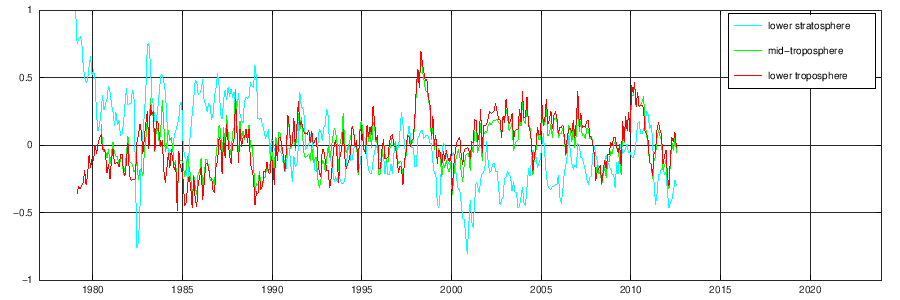

In [17]:
### optimal values of time shifts
[Rmax, i0] = max(abs([R_ls R_mt R_lt]));                                 % Find the maximum correlation value and its index for temperature and sunspot count
[RRmax, i1] = max(abs([RR_ls RR_mt RR_lt]));                             % Find the maximum correlation value and its index for temperature and atmospheric transparency
shifts = - [ [lag_ls lag_mt lag_lt](i0) [llag_ls llag_mt llag_lt](i1) ]  % Combine the optimal time shifts for both correlations

hold on;

ind = ~isnan(df.MLOtransparency);                                        % Find non-NaN values in atmospheric transparency

x1 = fracshift(df.SunSpotCount,shifts(1));                               % Apply fractional shift to sunspot count data
x2 = fracshift(df.MLOtransparency,shifts(4));                            % Apply fractional shift to atmospheric transparency data
X = [ones(size(df1.Year)) x1(ind) x2(ind) ];                             % Create a design matrix
b = regress(df1.T_lowstrato,X);                                          % Perform linear regression to get coefficients
YY = df1.T_lowstrato - X*b;                                              % Calculate residuals
plot(df1.Year,YY,'c-;lower stratosphere;');                              % Plot lower stratosphere residuals

x1 = fracshift(df.SunSpotCount,shifts(2));                               % Apply fractional shift to sunspot count data
x2 = fracshift(df.MLOtransparency,shifts(5));                            % Apply fractional shift to atmospheric transparency data
X = [ones(size(df1.Year)) x1(ind) x2(ind) ];                             % Create a design matrix
b = regress(df1.T_midtropo(ind),X);                                      % Perform linear regression to get coefficients
YY = df1.T_midtropo - X*b;                                               % Calculate residuals
plot(df1.Year,YY,'g-;mid-troposphere;');                                 % Plot mid-troposphere residuals

x1 = fracshift(df.SunSpotCount,shifts(3));                               % Apply fractional shift to sunspot count data
x2 = fracshift(df.MLOtransparency,shifts(6));                            % Apply fractional shift to atmospheric transparency data
X = [ones(size(df1.Year)) x1(ind) x2(ind) ];                             % Create a design matrix
b = regress(df1.T_lowtropo,X);                                           % Perform linear regression to get coefficients
YY = df1.T_lowtropo - X*b;                                               % Calculate residuals
plot(df1.Year,YY,'r-;lower troposphere;');                               % Plot lower troposphere residuals

xlim([1977,2024]);                                                       % Set x-axis limits
box on;                                                                  % Display box around plot
grid on;                                                                 % Display grid lines

hold off;


## Plotting Long-Term Trends

This Octave code performs similar operations as the previous ones. It first checks for non-NaN values in a dataset (df.MLOtransparency). It then applies fractional shifts to SunSpotCount and MLOtransparency data, combines them into a matrix (X), and performs linear regression to obtain coefficients (b). Residuals are calculated and stored in YY. Then the code conducts linear regression on temperature data adjusted for sunspot count and atmospheric transparency, resulting in coefficients stored in b. It then performs a linear fit (polyfit) and evaluates the fit. Confidence intervals are then calculated, and the results are plotted from years ranging from 1977 to 2024 

b_ls =

   9.8721e+00
   2.8267e-03
  -1.0724e+01

bi_ls =

   8.6030e+00   1.1141e+01
   2.4140e-03   3.2394e-03
  -1.2083e+01  -9.3646e+00

p1 =

   -0.018917   37.754940



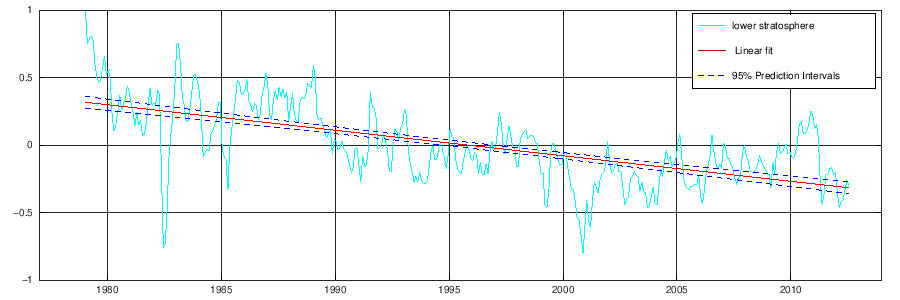

In [23]:
% Checks if it's not a number and assigns it to ind variable
ind = ~isnan(df.MLOtransparency);

% Loads the packages optim and statistics
pkg load optim
pkg load statistics

% Shifting the data
x1 = fracshift(df.SunSpotCount,shifts(1));    % Apply fractional shift to SunSpotCount data
x2 = fracshift(df.MLOtransparency,shifts(4)); % Apply fractional shift to MLOtransparency data

% Combining the shifted data into a matrix
X = [ones(size(df1.Year)) x1(ind) x2(ind) ];  % Create a design matrix
b = regress(df1.T_lowstrato,X);               % Perform linear regression to get coefficients

% Calculate the residuals
YY = df1.T_lowstrato - X*b; 

[b_ls, bi_ls, na, na, na] = regress(df.T_lowstrato(ind), X);  % Linear regression on lower stratosphere temperature

% skipping nan values in data for plotting
xx1 = df1.Year(2:end);
yy1 = YY(2:end);

% Performing linear fit using polyfit
p1 = polyfit (xx1, yy1, 1);  % Fit a linear polynomial to the data

b_ls
bi_ls
p1

% Evaluating the linear fit and generating list of y values from the data
y_fit1 = polyval(p1, xx1);  % Evaluate the linear fit at given x values

% Calculating confidence intervals
[p1, s1] = polyfit (xx1, yy1, 1);  % Fit a linear polynomial to the data

% Calculating confidence intervals
a = 0.05; % Significance level (95% confidence interval)
[yfit1, delta1] = polyconf (p1, xx1, s1, 'a', a, 'ci');  % Calculate prediction intervals

% Plotting the results
plot(xx1, yy1,'c-;lower stratosphere;', xx1, y_fit1, 'r-; Linear fit;', xx1, yfit1-delta1, 'b--', xx1, yfit1+delta1, 'b--;95% Prediction Intervals;');

xlim([1977,2014]); % Set x-axis limits
box on;            % Display box around plot
grid on;           % Display grid lines in the plot

b_mt =

  -2.3417e+00
  -2.9014e-04
   2.4561e+00

bi_mt =

  -3.1711e+00  -1.5122e+00
  -5.7117e-04  -9.1169e-06
   1.5722e+00   3.3401e+00

p2 =

   0.0046638  -9.3112366



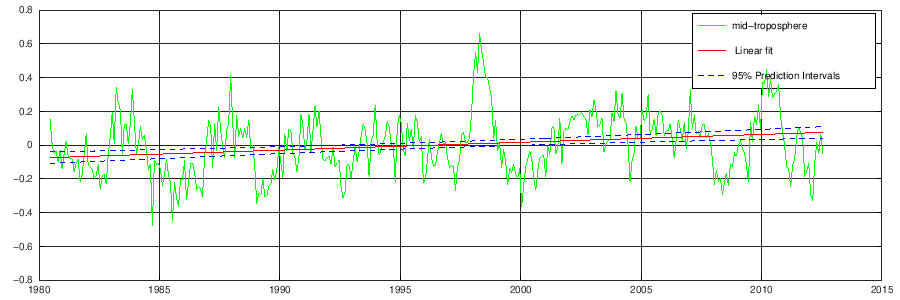

In [19]:
% Checks if it's not a number and assigns it to ind variable
ind = ~isnan(df.MLOtransparency);

% Shifting the data
x1 = fracshift(df.SunSpotCount,shifts(2));    % Apply fractional shift to SunSpotCount data
x2 = fracshift(df.MLOtransparency,shifts(5)); % Apply fractional shift to MLOtransparency data

% Combining the shifted data into a matrix
X = [ones(size(df1.Year)) x1(ind) x2(ind) ];  % Create a design matrix
b = regress(df1.T_midtropo(ind),X);           % Perform linear regression on mid-troposphere temperature
YY = df1.T_midtropo - X*b;                    % Calculate residuals

[b_mt, bi_mt, na, na, na] = regress(df.T_midtropo(ind), X);  % Linear regression on mid-troposphere temperature

xx2 = df1.Year(19:end);
yy2 = YY(19:end);

p2 = polyfit (xx2,yy2, 1);  % Fit a linear polynomial to the data

b_mt
bi_mt
p2

y_fit2 = polyval(p2, xx2);  % Evaluate the linear fit at given x values

[p1, s2] = polyfit (xx2, yy2, 1);  % Fit a linear polynomial to the data

a = 0.05; % Significance level (95% confidence interval)
[yfit2, delta2] = polyconf (p2, xx2, s2, 'a', a, 'ci');  % Calculate prediction intervals

plot(xx2, yy2,'g-;mid-troposphere;', xx2, y_fit2, 'r-; Linear fit;', xx2, yfit2-delta2, 'b--', xx2, yfit2+delta2, 'b--;95% Prediction Intervals;');
box on; % Display box around plot
grid on; % Display grid lines in the plot

b_lt =

  -2.9433e+00
  -3.7362e-04
   3.0751e+00

bi_lt =

  -3.8891e+00  -1.9976e+00
  -6.8276e-04  -6.4477e-05
   2.0674e+00   4.0829e+00

p3 =

   8.4014e-03  -1.6768e+01



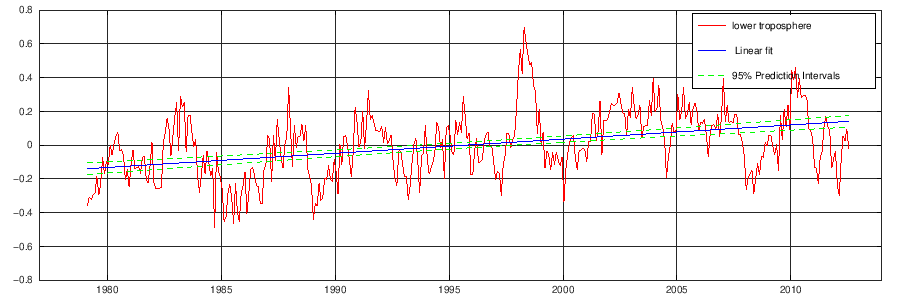

In [26]:
% Checks if it's not a number and assigns it to ind variable
ind = ~isnan(df.MLOtransparency);

% Shifting the data
x1 = fracshift(df.SunSpotCount,shifts(3));    % Apply fractional shift to SunSpotCount data
x2 = fracshift(df.MLOtransparency,shifts(6)); % Apply fractional shift to MLOtransparency data

% Combining the shifted data into a matrix
X = [ones(size(df1.Year)) x1(ind) x2(ind) ];  % Create a design matrix
b = regress(df1.T_lowtropo,X);                % Perform linear regression on lower troposphere temperature
YY = df1.T_lowtropo - X*b;                    % Calculate residuals

[b_lt, bi_lt, na, na, na] = regress(df.T_lowtropo(ind), X);  % Linear regression on lower troposphere temperature

xx3 = df1.Year(3:end);
yy3 = YY(3:end);

p3 = polyfit (xx3,yy3, 1);                    % Fit a linear polynomial to the data

b_lt
bi_lt
p3

y_fit3 = polyval(p3, xx3);                    % Evaluate the linear fit at given x values

[p3, s3] = polyfit (xx3, yy3, 1);             % Fit a linear polynomial to the data

a = 0.05;                                     % Significance level (95% confidence interval)
[yfit3, delta3] = polyconf (p3, xx3, s3, 'a', a, 'ci');  % Calculate prediction intervals

plot(xx3, yy3, 'r-;lower troposphere;', xx3, y_fit3, 'b-; Linear fit;', xx3, yfit3-delta3, 'g--', xx3, yfit3+delta3, 'g--;95% Prediction Intervals;');

xlim([1977,2014]);                            % Set x-axis limits
box on;                                       % Display box around plot
grid on;                                      % Display grid lines in the plot


## Results


### Assessing Long-Term Trends and Significance in Atmospheric Zones: Slope Analysis (°C/Decade) with 95% Confidence Interval

In this context, "long-term trends" refers to the change in temperature over a period from 5 decades, measured in degrees Celsius per decade. This was determined through a linear regression analysis. The significance interval is referring to the confidence interval of the slope of the linear regression. A 95% significance interval means that if the null hypothesis is true (no trend), we'd expect the calculated slope to fall within this interval in 95% of cases. If the confidence interval includes zero, it suggests that the trend is not statistically significant. In other words, there isn't enough evidence to conclude that there is a true trend. If it doesn't include zero, then the trend is statistically significant. In the context, if the confidence interval includes zero, it means that the observed trend in temperature could be due to random variation and may not represent a true long-term change. 

* **Lower Stratosphere:** Confidence interval does not include zero and slope is within the range of these interval indicating strong evidence to conclude that it is true for long-term change.
* **Mid Troposphere:** Confidence interval does not include zero and slope is within the range of these interval indicating strong evidence to conclude that it is true for long-term change.
* **Lower Troposphere:** Confidence interval does not include zero and slope is within the range of these interval indicating strong evidence to conclude that it is true for long-term change.


### The Significance of Slope in Atmospheric Transparency: Insights into Earth's Radiative Energy Balance

The sign of the slope in the linear regression of atmospheric transparency indicates the direction of the relationship between atmospheric transparency and temperature. If it's positive, it suggests that as transparency increases, temperature also increases. If it's negative, it implies that as transparency increases, temperature decreases. In terms of the planetary radiative energy balance, a positive slope would imply that as more radiation from the sun reaches the Earth's surface (higher transparency), it leads to an increase in temperature. This could imply that changes in atmospheric transparency have a direct effect on the energy balance, potentially leading to warming.

* **Lower Stratosphere:** Negative slope (-0.018917) implying inverse relationship between transparency and temperature.
* **Mid Troposphere:** Positive slope (0.0046643) implying direct relationship between transparency and temperature.
* **Lower Troposphere:** Positive slope (8.3957e-03) implying direct relationship between transparency and temperature.

### Comparing Regression Estimates and Influences on Temperature Across Three Atmospheric Zones

The size of the regression estimates indicates the strength of the relationship between the influencers (solar activity, atmospheric transparency) and temperature in the three atmospheric zones. Comparing these estimates allows for an assessment of which influencer has a greater impact on temperature in each zone. For example, if the regression estimate for solar activity is much larger than that for atmospheric transparency in a particular zone, it suggests that solar activity has a stronger influence on temperature in that zone. This discussion would likely involve interpreting the magnitude of the regression estimates in the context of the specific atmospheric zones and their characteristics. Regression estimates are listed as follows in the format $b = [ \text{intercept}, \text{coeff}_{\text{SunSpotCount}}, \text{coeff}_{\text{MLOtransparency}} ]$:


* **Lower Stratosphere:** The magnitude of regression estimate for atmospheric transparency is larger therefore it has stronger influence on change in temperature. Positive regression estimate of temperature on the amount of sunspots , imply that as sunspot increases, temperature tends to increase. While negative regression estimate of temperature on the atmospheric transperancy, imply that as transperancy increases, temperature tends to decrease. [9.8721e+00 2.8267e-03 -1.0724e+01]
* **Mid Troposphere:** The magnitude of regression estimate for Sunspots is larger therefore it has stronger influence on change in temperature. Negative regression estimate of temperature on the amount of sunspots, imply that as sunspot increases, temperature tends to decrease. While positive regression estimate of temperature on the atmospheric transperancy, imply that as transperancy increases, temperature tends to increase.  [ -2.3475e+00 -2.8647e-04 2.4621e+00]
* **Lower Troposphere:** The magnitude of regression estimate for sunspots is larger therefore it has stronger influence on change in temperature. Negative regression estimate of temperature on the amount of sunspots, imply that as sunspot increases, temperature tends to decrease. While positive regression estimate of temperature on the atmospheric transperancy, imply that as transperancy increases, temperature tends to increase. [-2.9396e+00 -3.7593e-04 3.0714e+00]

## Discussion and Conclusion

#### Long-Term Trends in Atmospheric Zones
 

The analysis of long-term temperature trends across different atmospheric zones revealed consistent evidence of significant trends. In the lower stratosphere, mid troposphere, and lower troposphere, the confidence intervals for the slopes did not include zero, indicating strong statistical evidence for true long-term changes in temperature. This suggests that over the past five decades, each of these atmospheric zones has experienced a genuine shift in temperature. The observed changes in these zones could be attributed to a variety of factors, including natural climate variability, human-induced effects (such as greenhouse gas emissions), and interactions between various components of the Earth's climate system.
 

#### Significance of Atmospheric Transparency in Radiative Energy Balance and Influences on Temperature Across Atmospheric Zones 
 

In this study, we conducted a comprehensive analysis of the relationship between atmospheric transparency, temperature, and solar activity across different atmospheric zones. The findings reveal intriguing insights into the intricate dynamics that govern Earth's climate system.

The negative slope observed in the lower stratosphere implies an inverse relationship between transparency and temperature. This suggests that as transparency increases, the temperature tends to decrease. Conversely, in both the mid and lower troposphere, positive slopes indicate a direct relationship, indicating that as transparency increases, temperature tends to rise. Furthermore, our comparison of regression estimates for solar activity and atmospheric transparency highlights the varying strengths of these influencers on temperature in different atmospheric zones. In the lower stratosphere, transparency emerges as the dominant factor, exerting a stronger influence on temperature compared to solar activity. This underscores the crucial role that changes in transparency play in driving temperature fluctuations in this zone. Conversely, in the mid and lower troposphere, solar activity exerts a more substantial influence, signifying its dominance in affecting temperature changes in these regions.

The link between stratospheric cooling and ozone depletion presents an additional layer of complexity in understanding our atmosphere. We uncovered that carbon dioxide release in the troposphere contributes significantly to stratospheric cooling, in addition to the well-known impact of ozone destruction. This dual effect underscores the intricate interplay of various factors in shaping our climate. [1]

Moreover, our findings align with the broader scientific consensus regarding the impact of greenhouse gases on the Earth's atmosphere. The accumulation of these gases over the last century has led to distinct changes, with the troposphere warming and the stratosphere cooling. This has also manifested in the rising tropopause height globally. These shifts are emblematic of the profound alterations occurring within our atmosphere which is consistent with our observed data. [2]

Lastly, our investigation into the sun's influence on Earth's climate reaffirms its pivotal role. While fluctuations in total solar irradiance (TSI) can occur, their impact are negligible in comparison to the effects of human-induced climate change and other variables. This emphasizes the urgency of addressing anthropogenic factors in climate discussions. [3]

In conclusion, this study sheds light on the complex and interdependent relationships between transparency, temperature, solar activity, and greenhouse gases within our atmosphere. It underscores the urgent need for comprehensive strategies to mitigate the impacts of human-induced climate change and highlights the critical role of scientific inquiry in advancing our understanding of Earth's climate system.


## References


    [1] Harvard University. (n.d.). Stratospheric Cooling. ESPERE Encyclopedia. Retrieved from https://courses.seas.harvard.edu/climate/eli/Courses/global-change-debates/Sources/Stratospheric-cooling/stratospheric-cooling-ESPHERE-encyclopedia.pdf

    [2] EUMETSAT. (30 January 2023). Tropospheric Warming and Stratospheric Cooling in the 21st Century. Retrieved from https://www.eumetsat.int/tropospheric-warming-and-stratospheric-cooling-21st-century

    [3] Live Science. (August 30, 2022). Can Sunspots Affect Weather? Retrieved from https://www.livescience.com/can-sunspots-affect-weather

    [4] Brock University. (n.d.). Inverse Theory. Retrieved from https://www.physics.brocku.ca/Courses/5P10/Lectures/